In [1]:
import pandas as pd
import numpy as np
from numba import jit

In [2]:
us = pd.read_csv('../covid-19-data/us.csv', parse_dates=['date'])

In [3]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['figure.max_open_warning'] = 0

In [4]:
dates = us['date']
us_daily_cases = us['cases'].diff().fillna(0)
us_daily_deaths = us['deaths'].diff().fillna(0)

In [5]:
may31 = 496
dates[may31]

Timestamp('2021-05-31 00:00:00')

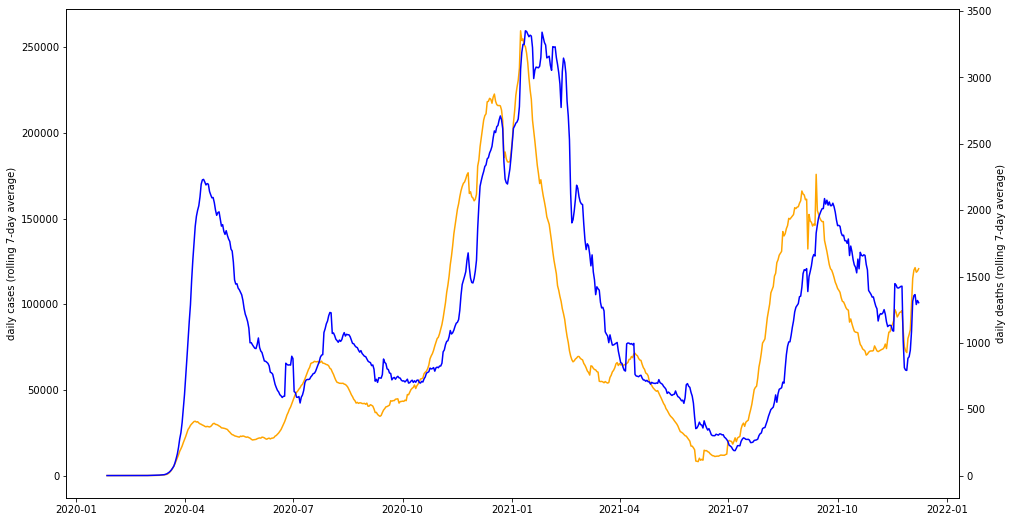

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel('daily cases (rolling 7-day average)')
ax2.set_ylabel('daily deaths (rolling 7-day average)')

p = ax1.plot(dates,us_daily_cases.rolling(7).mean(),color='orange')
p = ax2.plot(dates,us_daily_deaths.rolling(7).mean(), color='blue')

In [7]:
from math import pi, exp, sqrt, log
from scipy.optimize import curve_fit

In [8]:
@jit(nopython=True)
def gauss(x, mu, sigma):
    # normalized to unit integral
    norm = 1.0/(sigma * sqrt(2*pi))
    arg = -0.5 * ((x - mu)/sigma)**2
    return norm * exp(arg)

In [9]:
@jit(nopython=True)
def normfn(i, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, norm4_end, norm5):
    if i < norm1_end:
#        return (norm2 - norm1)/norm1_end * i + norm1
        return norm1
    elif i < norm2_end:
        return (norm3 - norm2)/(norm2_end - norm1_end) * (i - norm1_end) + norm2
    elif i < norm3_end:
        return (norm4 - norm3)/(norm3_end - norm2_end) * (i - norm2_end) + norm3
    elif i < norm4_end:
        return (norm5 - norm4)/(norm4_end - norm3_end) * (i - norm3_end) + norm4
    else:
        return norm5

In [10]:
@jit(nopython=True)
def full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, norm4_end, norm5, offset, width):
    num = len(newcases)
    retval = np.zeros(num, np.float64)
    for i in range(0, num):
        for j in range(1, i):
            retval[i] += newcases[j] * normfn(j, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, norm4_end, norm5) * gauss(i-j, offset, width)
    return retval

In [11]:
norm1_end = 75
norm2_end = 150
norm3_end = 200
norm4_end = may31
sigma = 18
@jit(nopython=True)
def model1(newcases, norm1, norm2, norm3, norm4, norm5, offset):
    global norm1_end, norm2_end, norm3_end, norm4_end, sigma
    return full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, norm4_end, norm5, offset, sigma)

In [12]:
def us_fit(dates, daily_cases, daily_deaths, plot=True):
    sigma = np.ones(len(daily_cases))
    sigma[0:150] = 10
    #popt, pcov = curve_fit(model1, dc, dd, [10, 0.1, 0.1, 0.002, 0.002, 18], sigma)
    popt, pcov = curve_fit(model1, daily_cases.to_numpy(), daily_deaths.to_numpy(),
        [10, 0.1, 0.1, 0.002, 0.002, 18], sigma)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(dates, daily_deaths.rolling(7).mean(), color='blue', label='observed deaths')
        ax.plot(dates, model1(daily_cases.to_numpy(), *popt), color='red', label='model deaths')
        ax.axvspan(dates[0], dates[149], alpha=0.2)
    return popt, pcov

In [13]:
len(us_daily_cases)

688

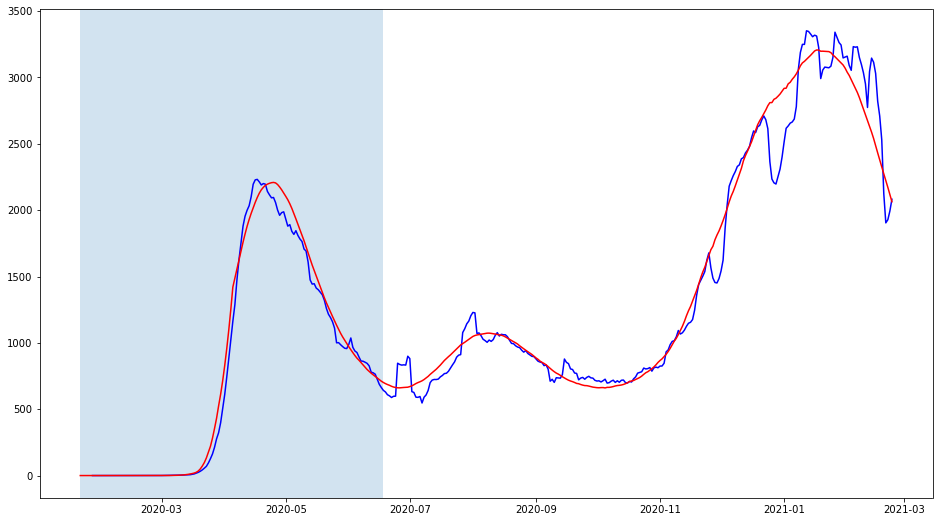

In [14]:
fitend = 400
popt, pcov = us_fit(dates[:fitend], us_daily_cases[:fitend], us_daily_deaths[:fitend])

In [15]:
popt

array([2.65790334e-01, 5.34661513e-02, 2.64685803e-02, 1.88200287e-02,
       1.64080750e-02, 1.92078056e+01])

In [16]:
perr = np.sqrt(np.diag(pcov))
perr

array([1.47538643e-01, 2.89919893e-02, 4.11260027e-03, 1.42749032e-03,
       2.45829695e-03, 2.64283983e+00])

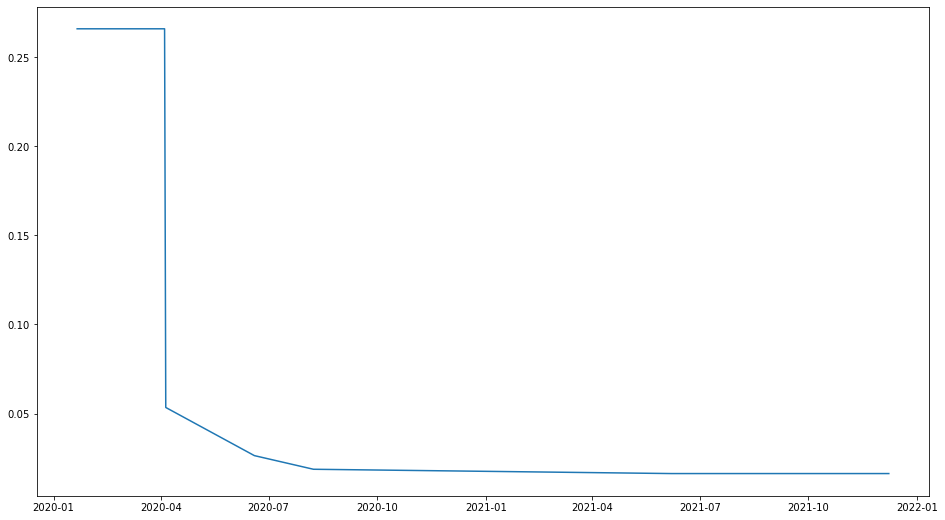

In [17]:
plt.plot(dates, 
    [normfn(i, popt[0], norm1_end, popt[1], norm2_end, popt[2], norm3_end, popt[3], norm4_end, popt[4]) for i in range(0, len(dates))]);

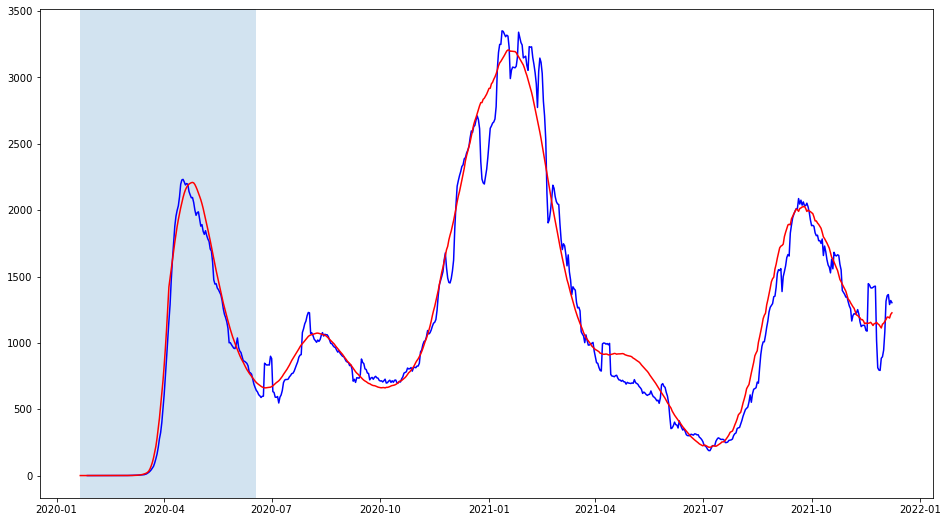

In [18]:
fig, ax = plt.subplots()
ax.plot(dates, us_daily_deaths.rolling(7).mean(), color='blue', label='observed deaths')
ax.plot(dates, model1(np.array(us_daily_cases), *popt), color='red', label='model deaths')
ax.axvspan(dates[0], dates[149], alpha=0.2)



In [19]:
indices = range(0, len(dates))
past_days = 15
start_recent = len(dates) - past_days
recent_dates = dates[start_recent:]
recent_indices = indices[start_recent:]
recent_smooth_cases = us_daily_cases.rolling(7).mean()[start_recent:]
log_recent_smooth_cases = [log(x) for x in recent_smooth_cases]

In [20]:
order = 0
coeffs, coeff_cov = np.polyfit(recent_indices, log_recent_smooth_cases, order, cov=True)
log_case_model = np.poly1d(coeffs)
last = recent_indices[-1]
future_num = 30
future_indices = range(last, last + future_num)

In [21]:
print("polynomial coeffs", coeffs)
print("polynomial coeff errs", np.sqrt(np.diag(coeff_cov)))

polynomial coeffs [-1.57150907e-03  3.20912854e+00 -2.18432776e+03  4.95585984e+05]
polynomial coeff errs [1.63103341e-04 3.32731289e-01 2.26252965e+02 5.12819780e+04]


In [22]:
n = len(us_daily_cases)
N = n + future_num
future_dates = pd.date_range(dates[0], periods=N)
future_cases = np.zeros(N, np.float64)
future_cases[0:n] = us_daily_cases.rolling(7).mean().fillna(0)
future_cases[n:] =  [exp(log_case_model(i)) for i in future_indices]

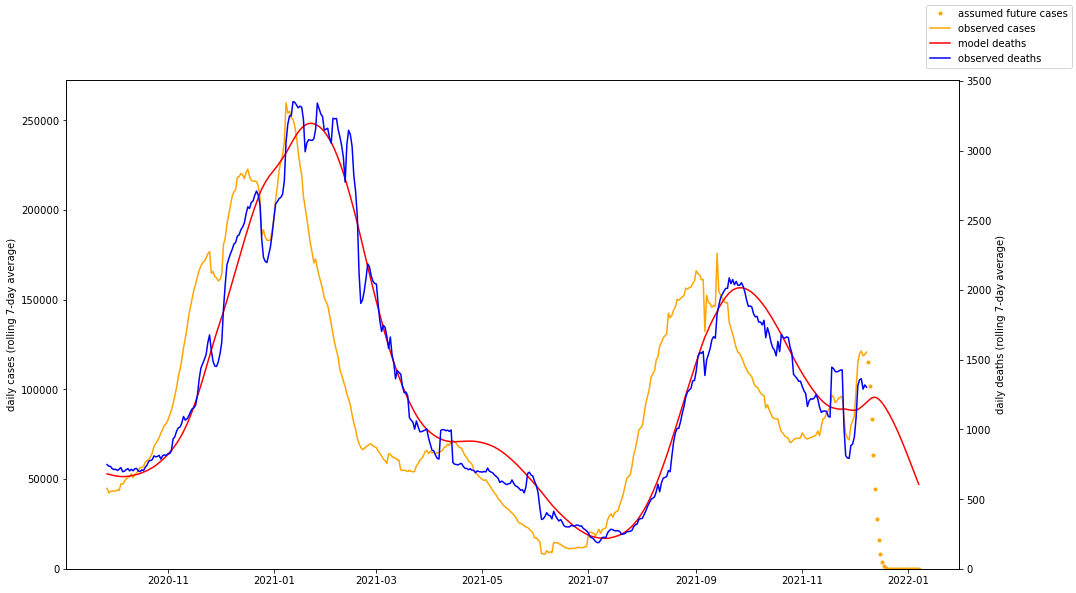

In [23]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel('daily cases (rolling 7-day average)')
ax2.set_ylabel('daily deaths (rolling 7-day average)')

start = 250
p = ax1.plot(future_dates[n:], future_cases[n:], '.', color='orange', label='assumed future cases')
#p = ax1.plot(dates[start:], us_daily_cases.rolling(7).mean()[start:],color='blue', label='observed cases')
p = ax1.plot(dates[start:], us_daily_cases.rolling(7).mean()[start:],color='orange', label='observed cases')
p = ax2.plot(future_dates[start:], model1(future_cases, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])[start:], color='red', label='model deaths')
p = ax2.plot(dates[start:], us_daily_deaths.rolling(7).mean()[start:], color='blue', label='observed deaths')

yl1 = ax1.get_ylim()
ax1.set_ylim([0, yl1[1]])

yl2 = ax2.get_ylim()
ax2.set_ylim([0, yl2[1]])
fig.legend();

In [24]:
states = pd.read_csv('../covid-19-data/us-states.csv', parse_dates=['date'])

In [25]:
state_deaths = states.pivot(index='date', columns='state', values='deaths')
state_cases =  states.pivot(index='date', columns='state', values='cases')
all_states = states['state'].unique()
all_states.sort()

In [26]:
norm1 = popt[0]
norm2 = popt[1]
offset = popt[-1]
@jit(nopython=True)
def model2(newcases, norm3, norm4, norm5):
    global norm1_end, norm2_end, norm3_end, norm4_end, sigma
    global norm1, norm2, offset
    return full_model(newcases, norm1, norm1_end, norm2, norm2_end, norm3, norm3_end, norm4, norm4_end, norm5, offset, sigma)
    

In [27]:
def state_fit(state, state_cases, state_deaths, plot=True):
    daily_cases = state_cases[state].diff().fillna(0)
    daily_deaths = state_deaths[state].diff().fillna(0)
    sigma = np.ones(len(daily_cases))
    sigma[0:150] = 10
    popt, pcov = curve_fit(model2, daily_cases.to_numpy(), us_daily_deaths.to_numpy(),
            [0.002, 0.002, 0.002], sigma)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(dates, daily_deaths.rolling(7).mean(), color='orange', label='observed deaths')
        ax.plot(dates, model2(daily_cases.to_numpy(), *popt), color='red', label='model deaths')
        ax.axvspan(dates[0], dates[149], alpha=0.2)
        plt.title("{state} fatality rate: {percentnorm:0.2f}%"
                  .format(state=state, percentnorm=100*popt[1]))
    print("{state} fatality rate: {percentnorm:0.2f}%"
          .format(state=state, percentnorm=100*popt[1]))
    return popt

In [28]:
for state in all_states:
    state_fit(state, state_cases, state_deaths, False);

Alabama fatality rate: 127.95%
Alaska fatality rate: 908.21%
American Samoa fatality rate: 0.20%
Arizona fatality rate: 57.98%
Arkansas fatality rate: 182.36%


/Users/amundson/opt/miniforge3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


California fatality rate: 8.56%
Colorado fatality rate: 101.68%
Connecticut fatality rate: 139.24%
Delaware fatality rate: 665.42%
District of Columbia fatality rate: 1785.79%
Florida fatality rate: 40.31%
Georgia fatality rate: 63.25%
Guam fatality rate: 3700.93%
Hawaii fatality rate: 1464.01%
Idaho fatality rate: 286.70%
Illinois fatality rate: 25.17%
Indiana fatality rate: 60.43%
Iowa fatality rate: 97.59%
Kansas fatality rate: 133.08%
Kentucky fatality rate: 148.57%
Louisiana fatality rate: 183.09%
Maine fatality rate: 1398.05%
Maryland fatality rate: 137.91%
Massachusetts fatality rate: 78.62%
Michigan fatality rate: 77.60%
Minnesota fatality rate: 79.10%
Mississippi fatality rate: 230.89%
Missouri fatality rate: 80.02%
Montana fatality rate: 397.72%
Nebraska fatality rate: 149.00%
Nevada fatality rate: 154.82%
New Hampshire fatality rate: 754.19%
New Jersey fatality rate: 71.60%
New Mexico fatality rate: 217.23%
New York fatality rate: 35.82%
North Carolina fatality rate: 74.10%


In [66]:
def state_fit_full(state, state_cases, state_deaths, plot=True):
    daily_cases = state_cases[state].diff().fillna(0)
    dc = np.array(daily_cases)
    daily_deaths = state_deaths[state].diff().fillna(0)
    dd = np.array(daily_deaths)
    sigma = np.ones(len(daily_cases))
    sigma[0:150] = 10
    popt, pcov = curve_fit(model1, dc, dd, [10, 0.1, 0.1, 0.002, 0.002, 18], sigma)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(dates, daily_cases.rolling(7).mean()*popt[3], color='blue', label='observed cases')
        ax.plot(dates, daily_deaths.rolling(7).mean(), color='orange', label='observed deaths')
        ax.plot(dates, model1(dc, *popt), color='red', label='model deaths')
        ax.axvspan(dates[0], dates[149], alpha=0.2)
        plt.title("{state} fatality rate: {percentnorm1:0.2f}% -> {percentnorm2:0.2f}%"
                  .format(state=state, percentnorm1=100*popt[3], percentnorm2=100*popt[4]))
    print("{state} fatality rate: {percentnorm:0.2f}%"
          .format(state=state, percentnorm=100*popt[4]))
    print("{state} fit: {popt}".format(state=state, popt=popt))
    return popt, pcov

Alabama fatality rate: 2.02%
Alabama fit: [-3.57828030e-02  1.50093365e-01  4.44640990e-03  2.64594999e-02
  2.02481113e-02  2.76776279e+01]
Alaska fatality rate: 0.88%
Alaska fit: [3.89701310e-02 3.54537886e-02 1.19713590e-02 4.68070643e-03
 8.80037887e-03 1.37351840e+01]


/Users/amundson/opt/miniforge3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


American Samoa fatality rate: 0.20%
American Samoa fit: [1.0e+01 1.0e-01 1.0e-01 2.0e-03 2.0e-03 1.8e+01]
Arizona fatality rate: 1.86%
Arizona fit: [ 0.25984414  0.05601358  0.03108333  0.02832589  0.01864213 14.88903773]
Arkansas fatality rate: 2.91%
Arkansas fit: [-0.06774017  0.21190476  0.00671839  0.0407944   0.0291163   0.07705555]
California fatality rate: 1.14%
California fit: [1.73611976e-01 6.31507728e-02 1.73471774e-02 1.94048430e-02
 1.14322313e-02 2.94146756e+01]
Colorado fatality rate: 1.58%
Colorado fit: [0.2173249  0.09580193 0.01486127 0.02101357 0.01578081 6.51778442]
Connecticut fatality rate: 0.79%
Connecticut fit: [5.43540020e-01 1.07389208e-01 1.29157269e-02 2.92136097e-02
 7.87194716e-03 1.37035656e+01]
Delaware fatality rate: 0.93%
Delaware fit: [4.30924789e-01 7.15782535e-02 6.85400196e-03 1.67222705e-02
 9.33218261e-03 3.70938464e+01]
District of Columbia fatality rate: 0.45%
District of Columbia fit: [3.82505527e-01 6.11373134e-02 1.40723832e-04 2.98931238e-0

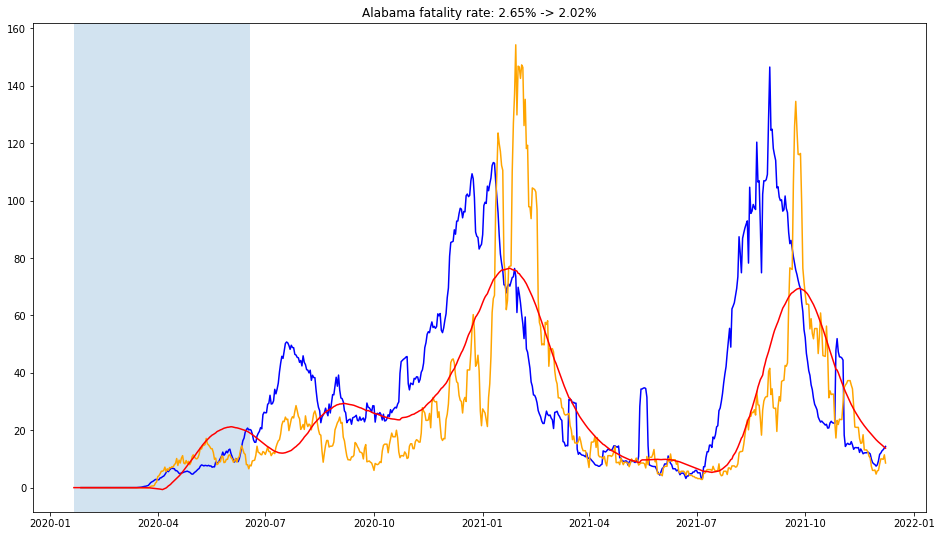

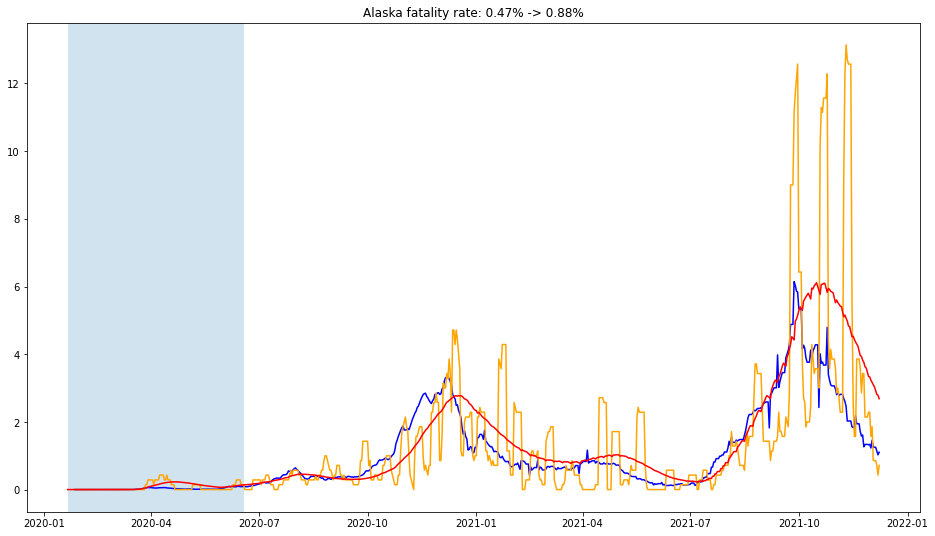

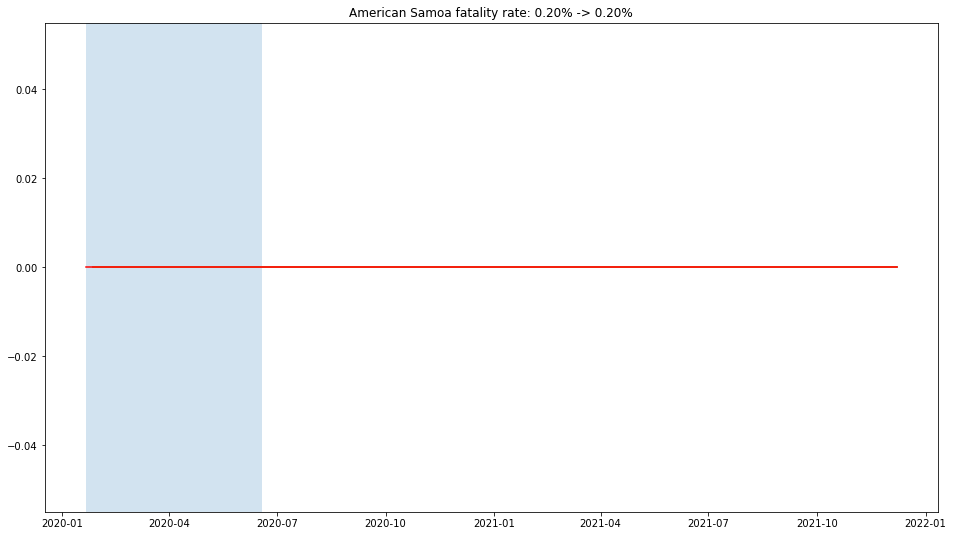

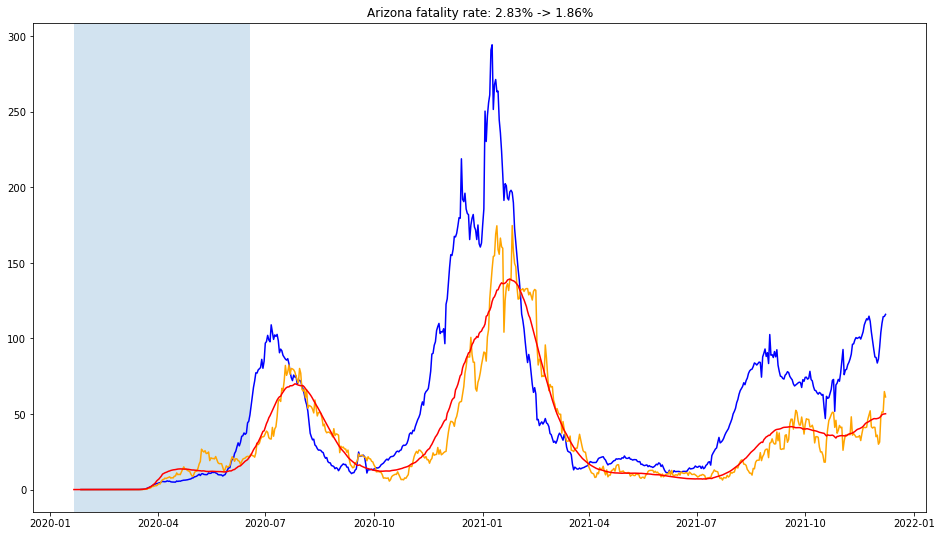

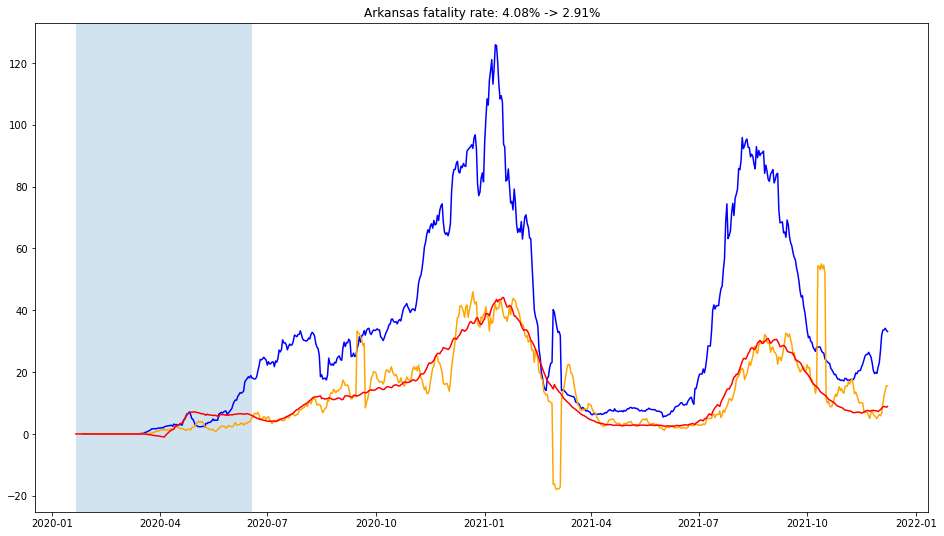

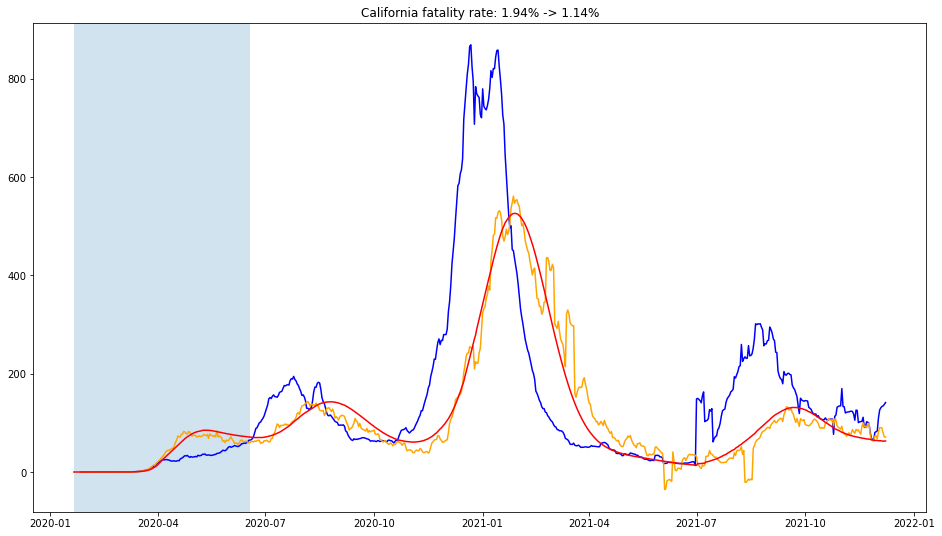

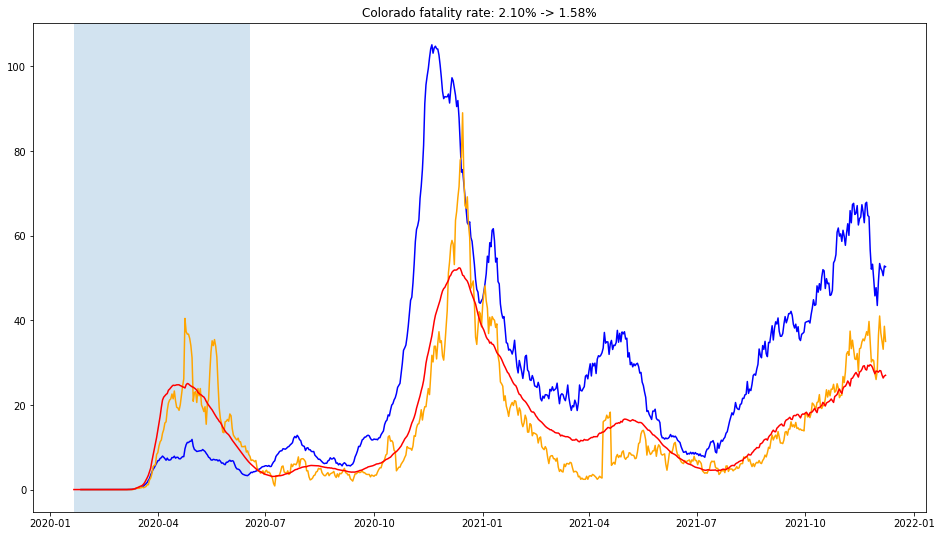

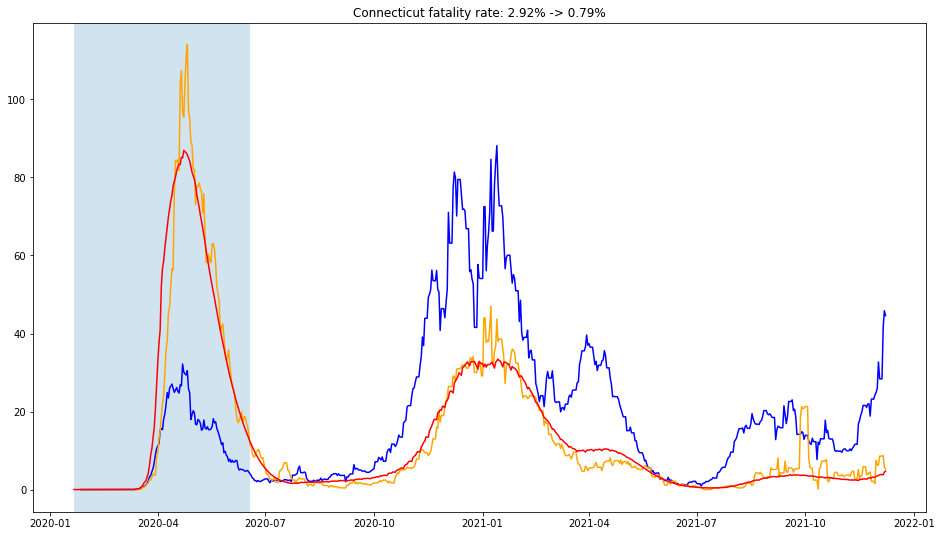

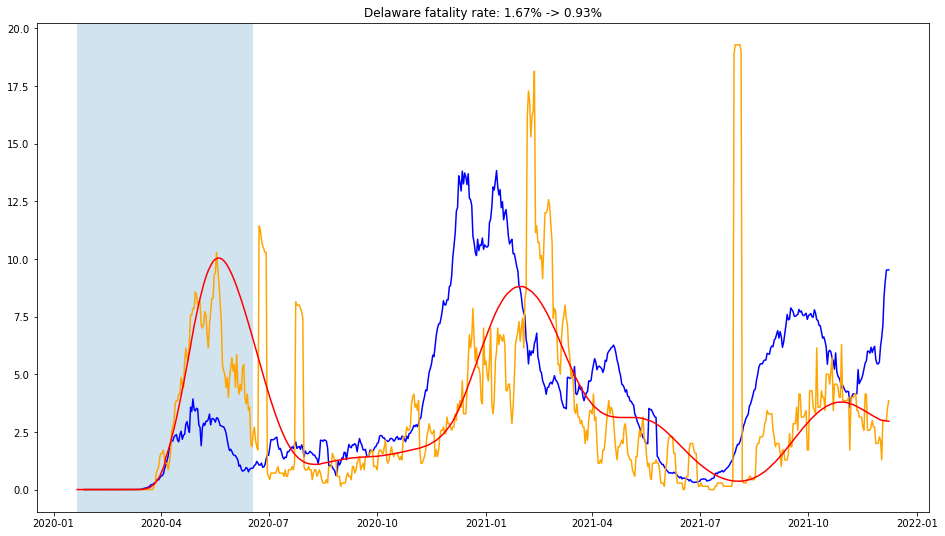

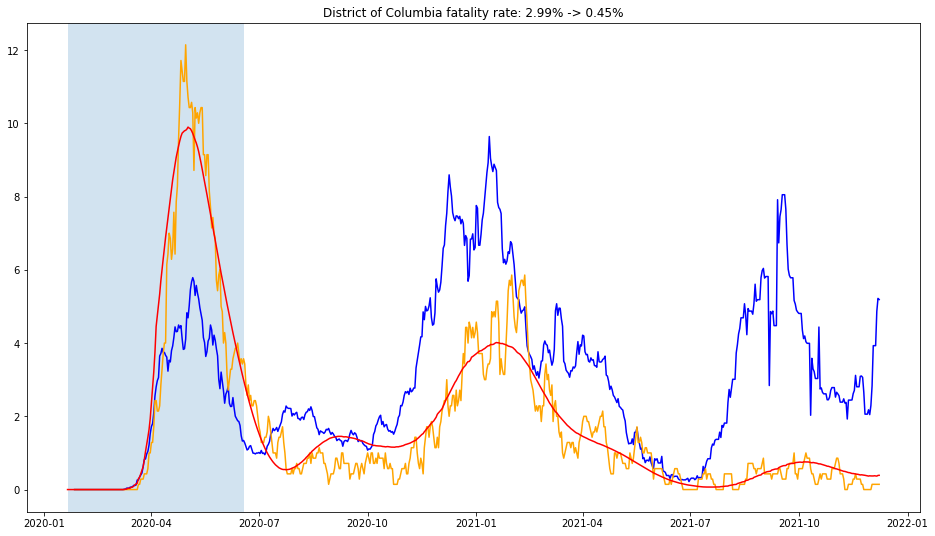

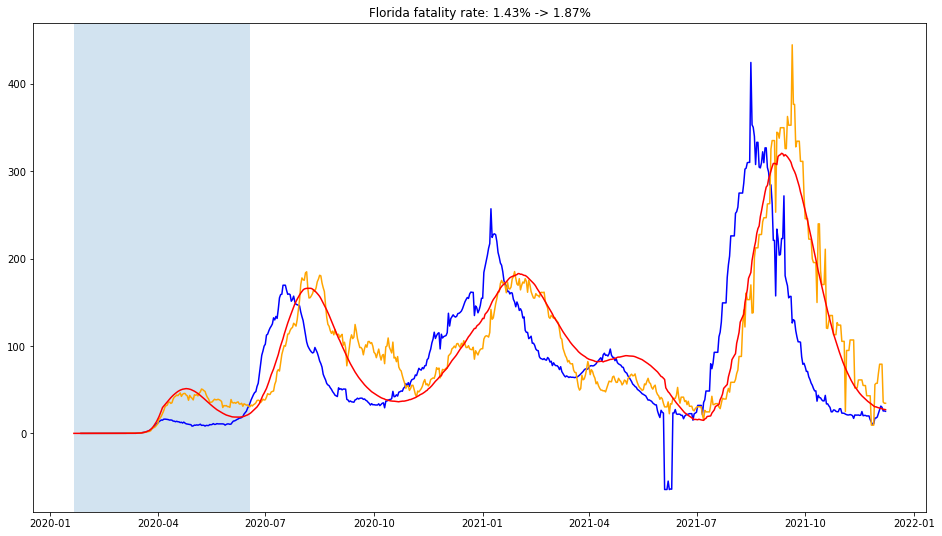

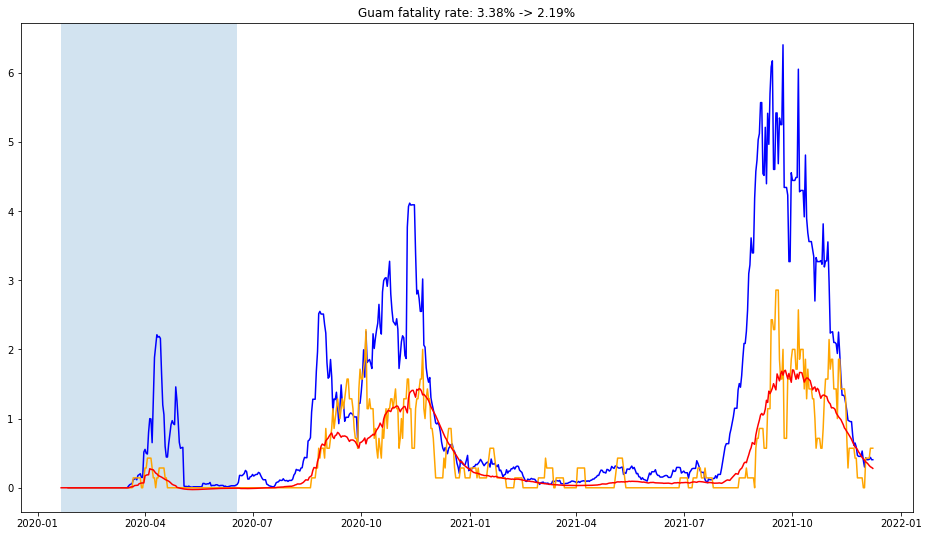

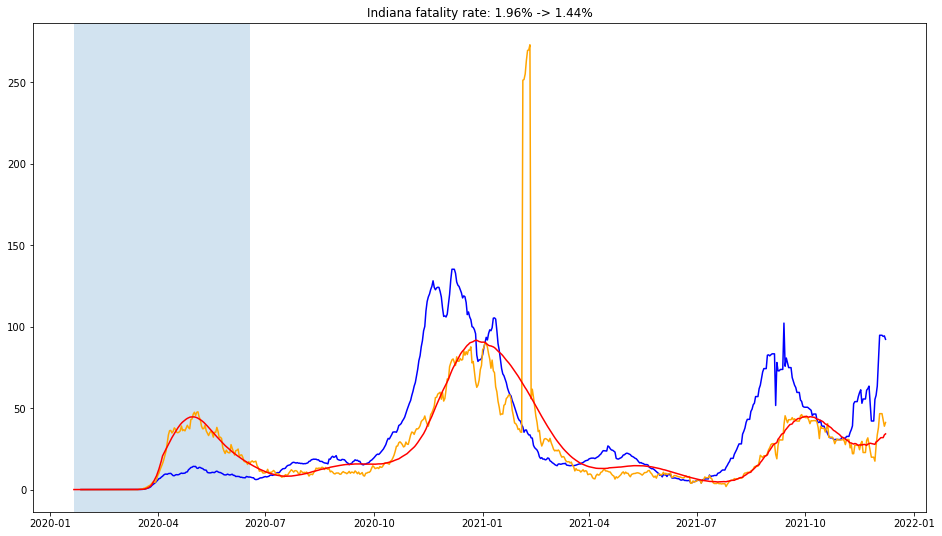

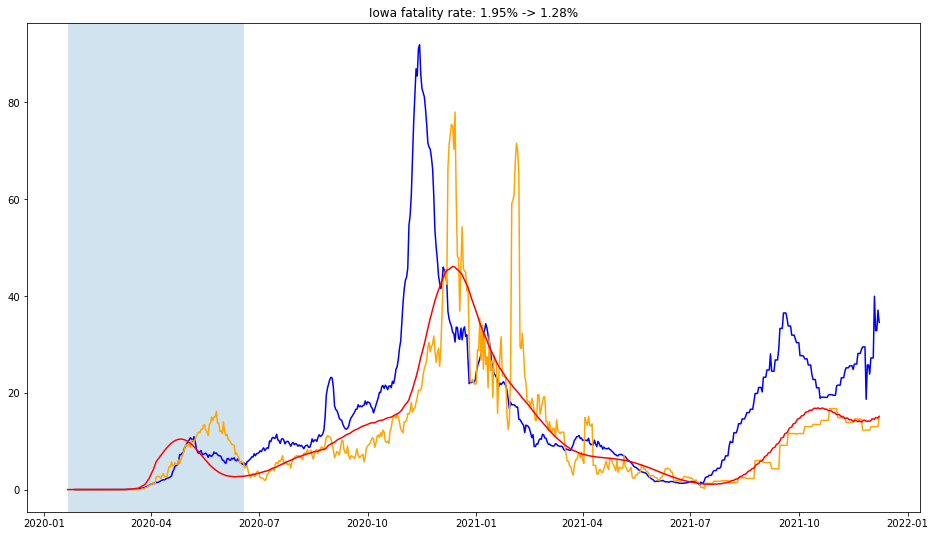

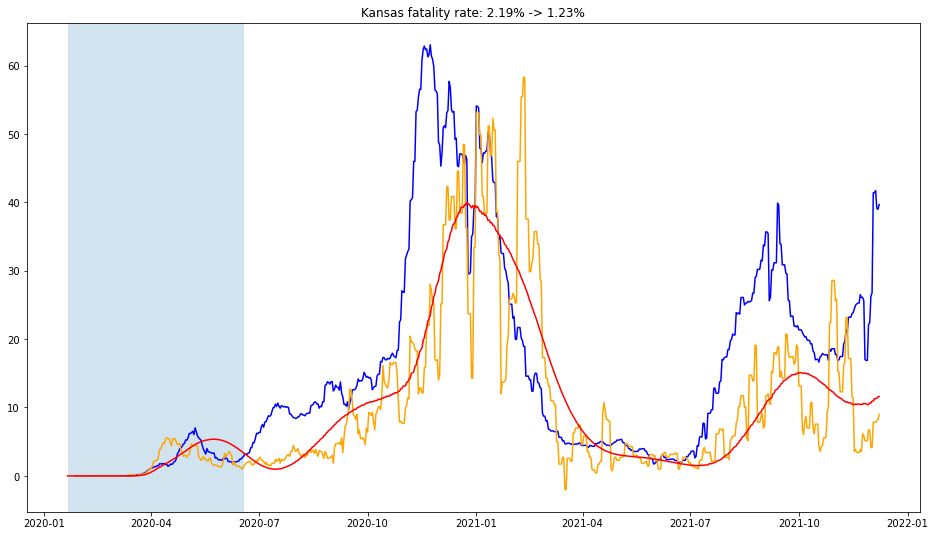

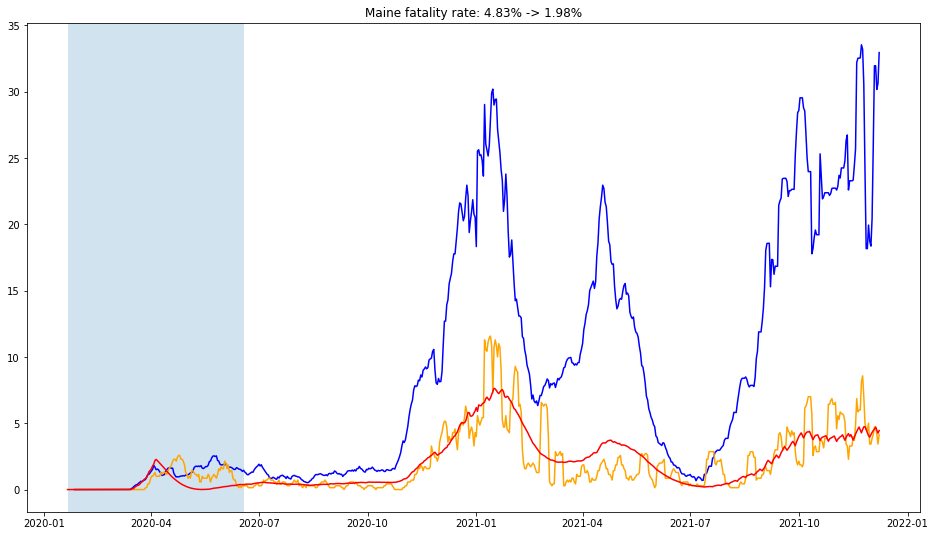

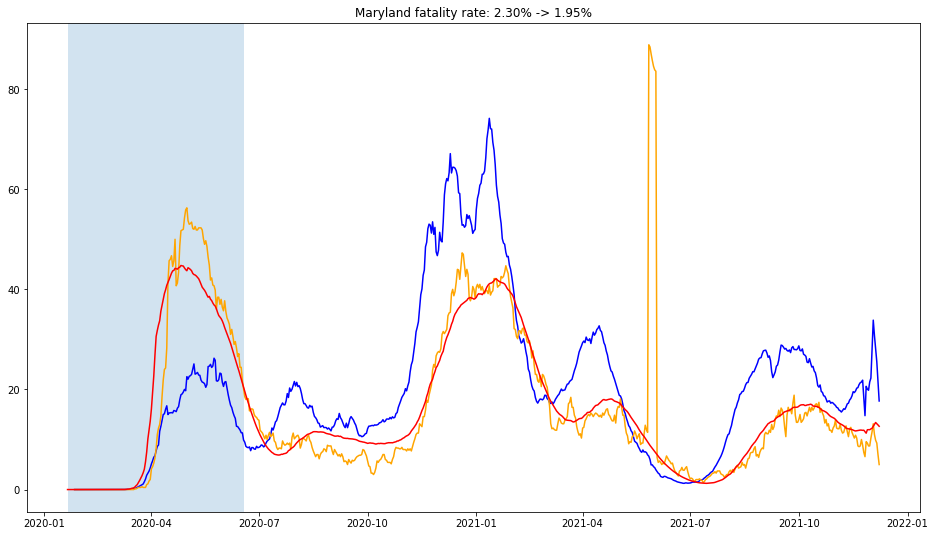

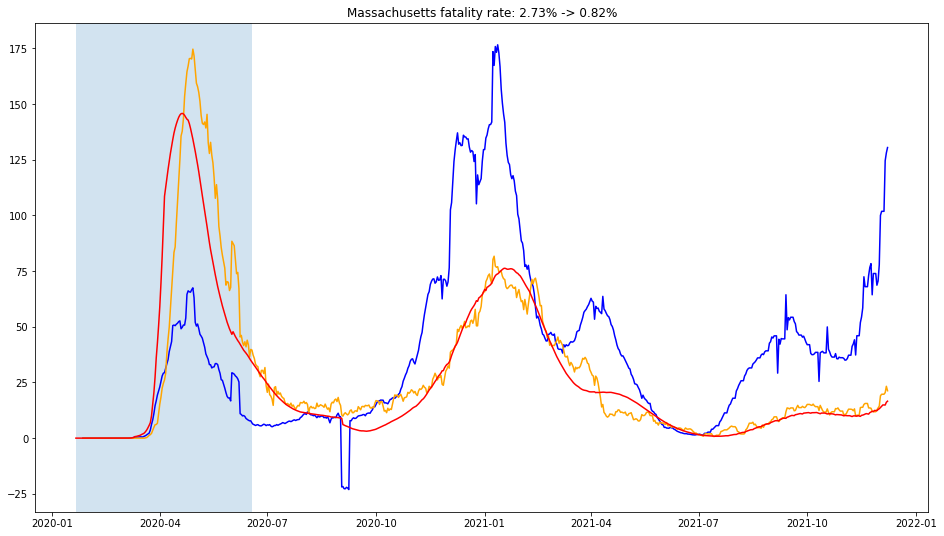

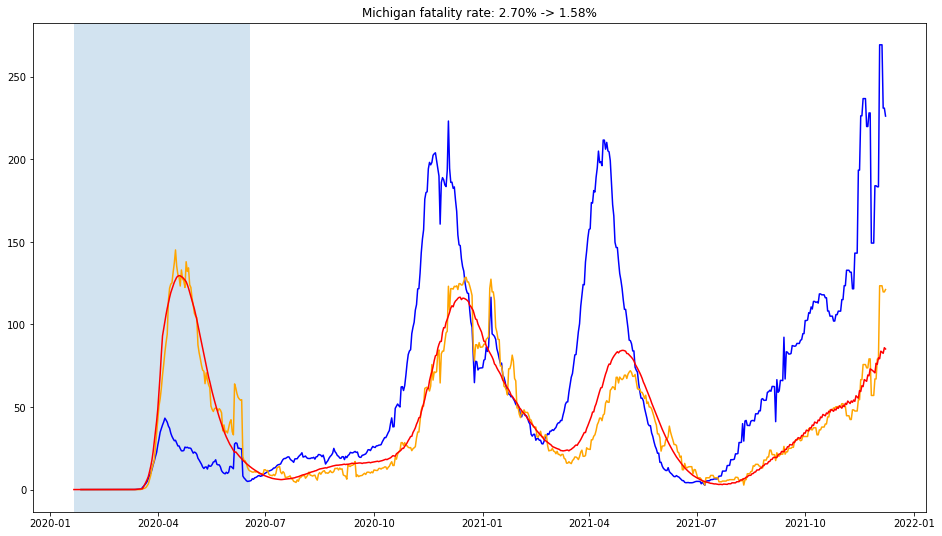

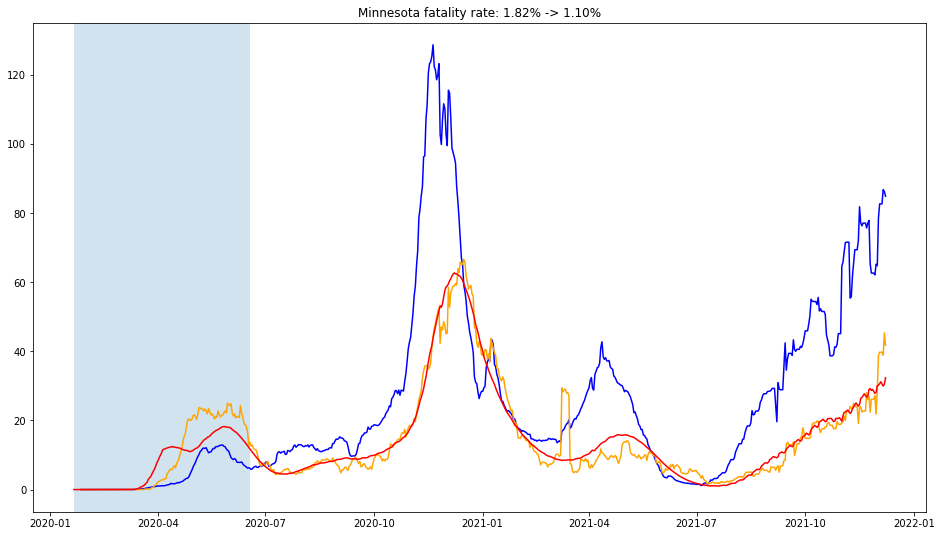

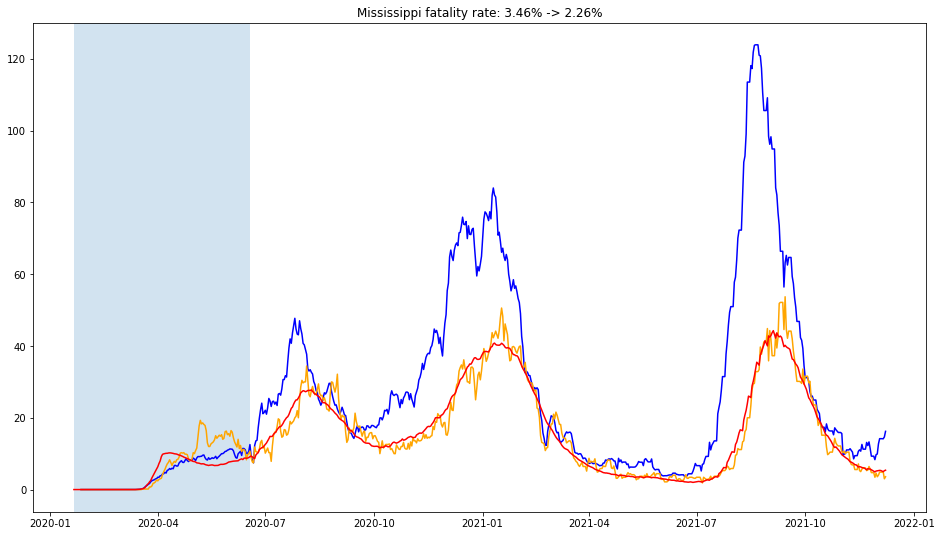

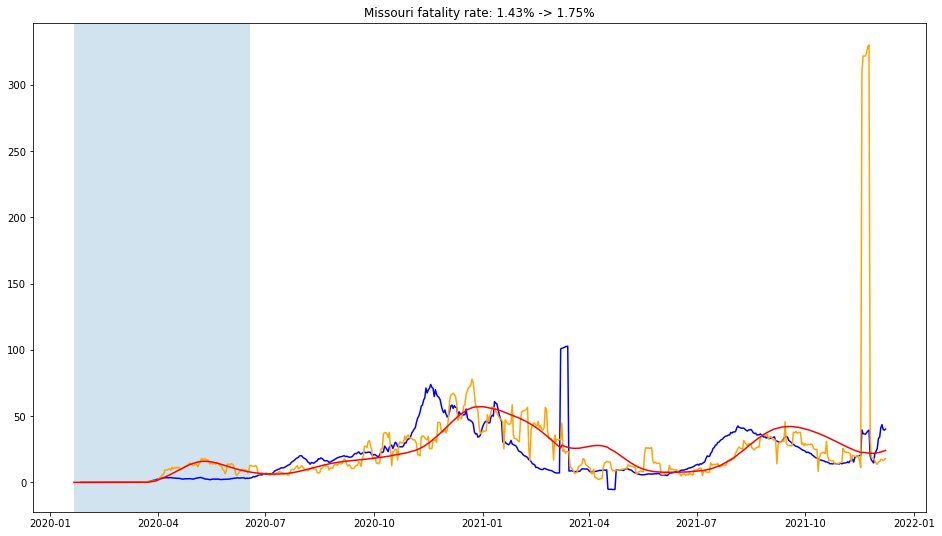

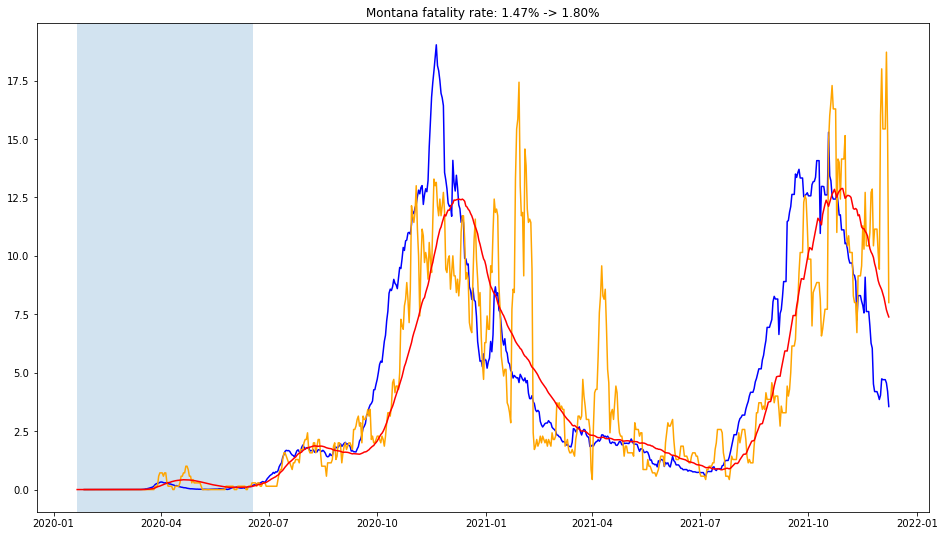

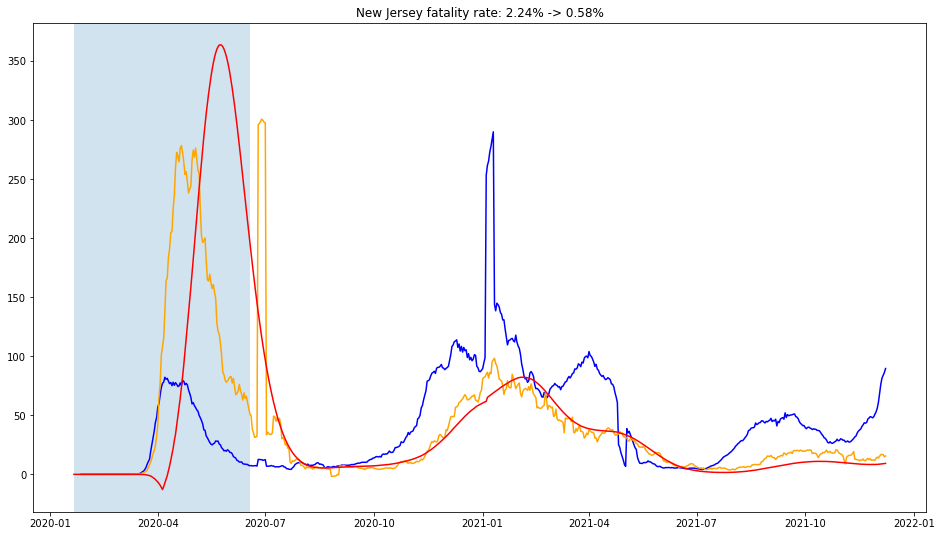

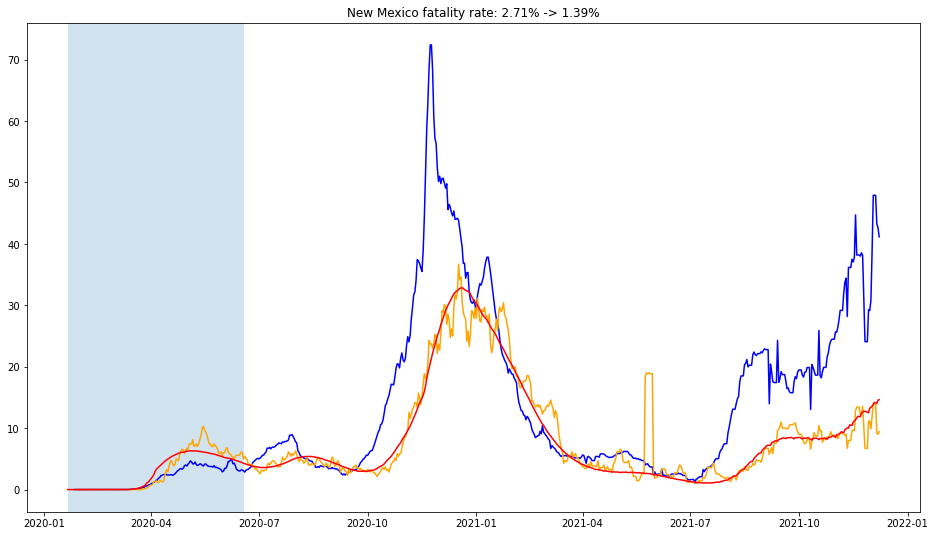

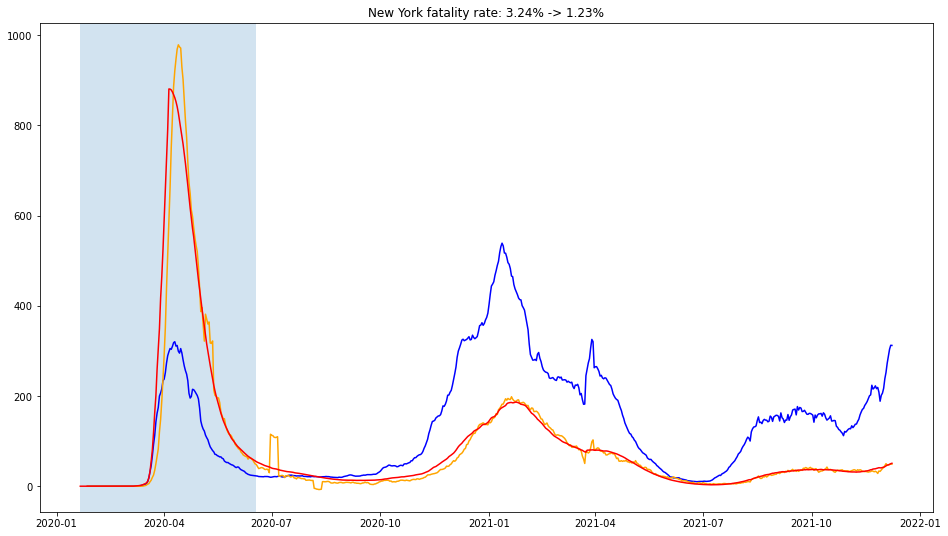

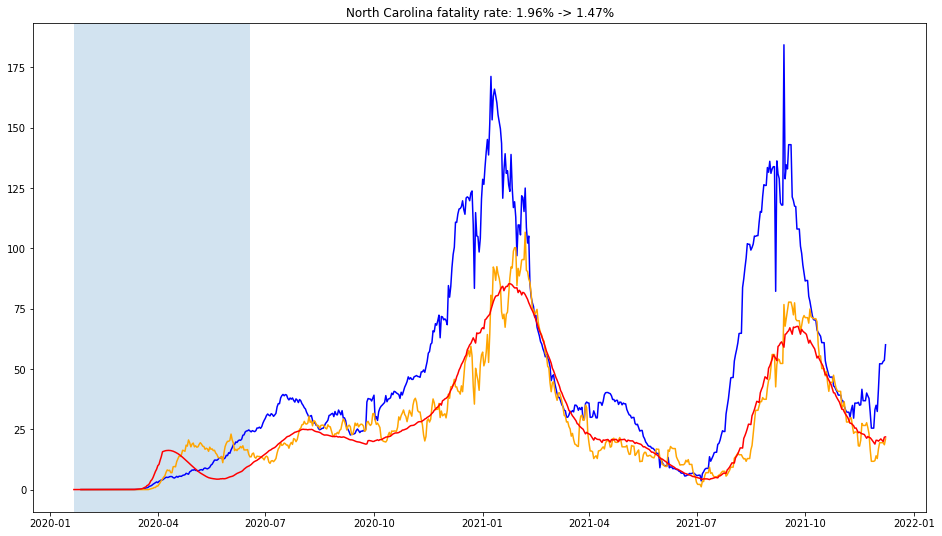

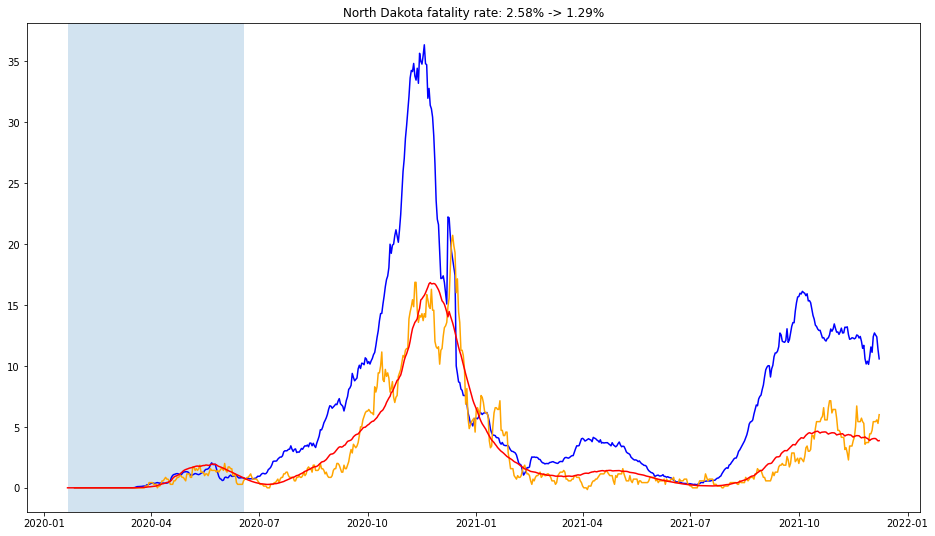

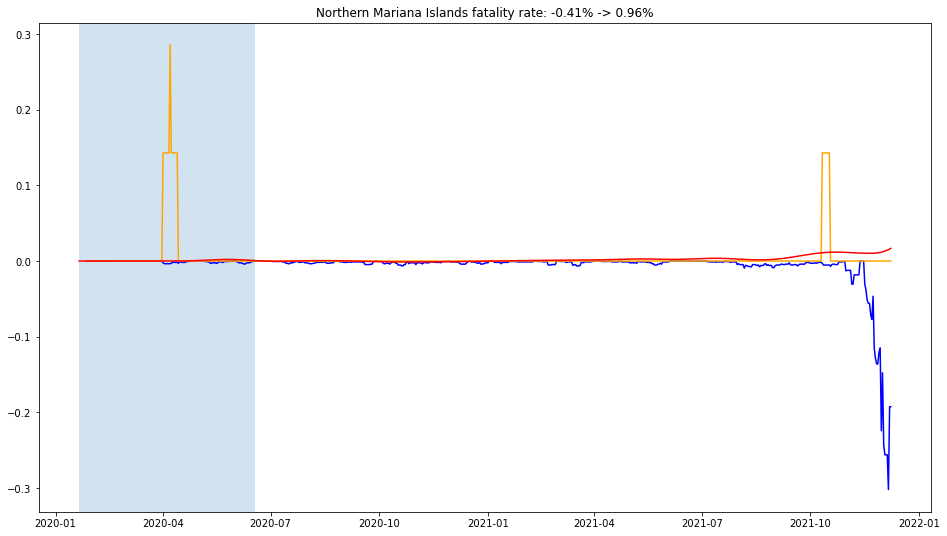

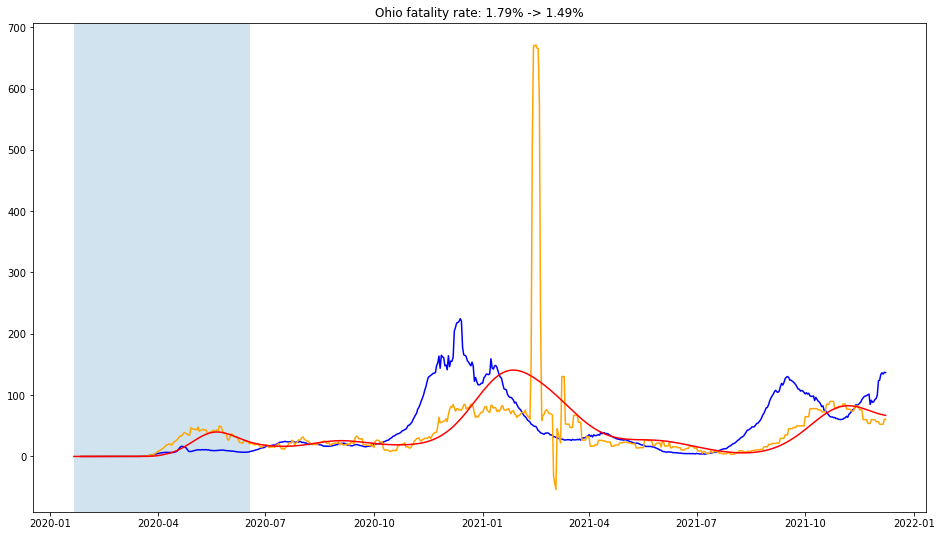

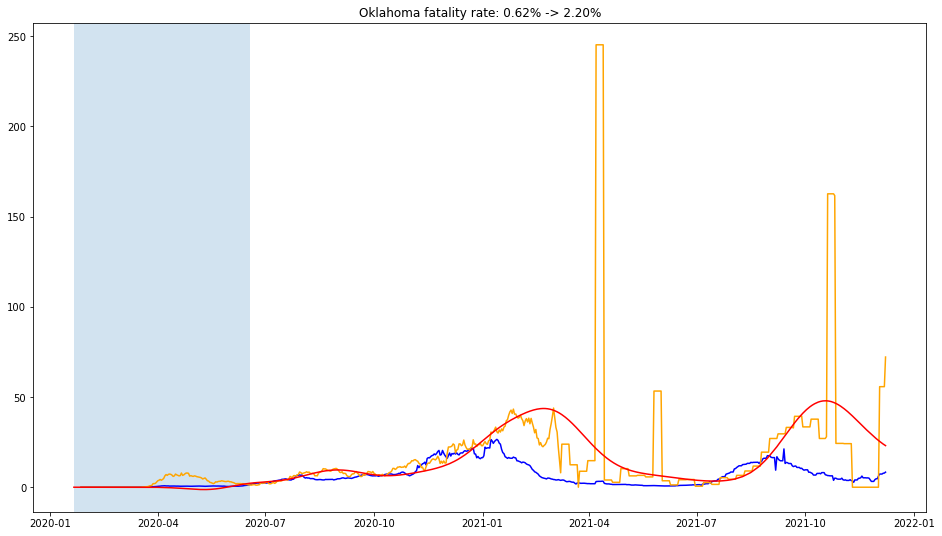

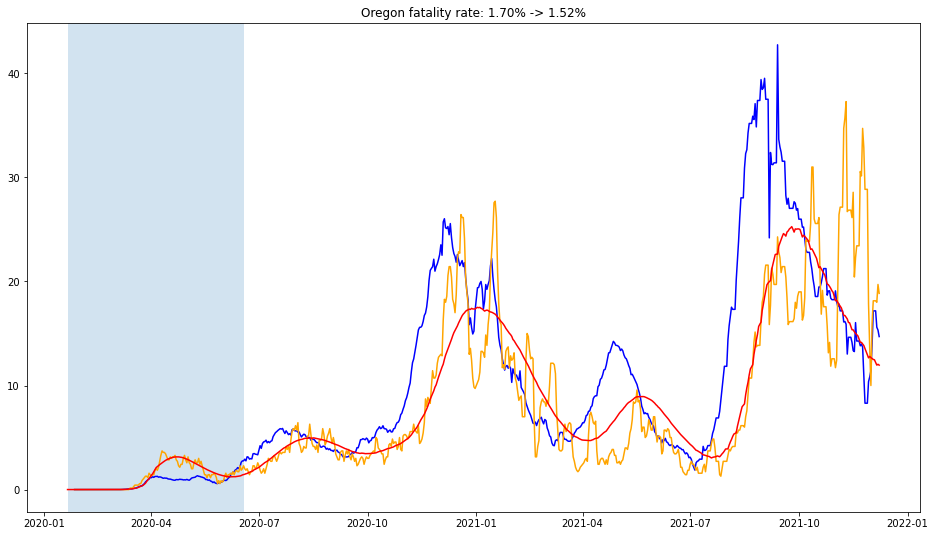

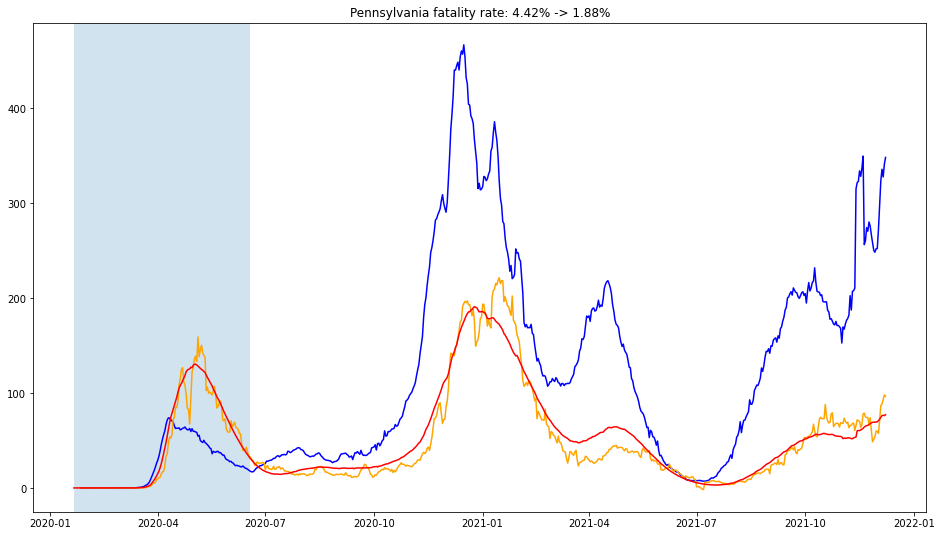

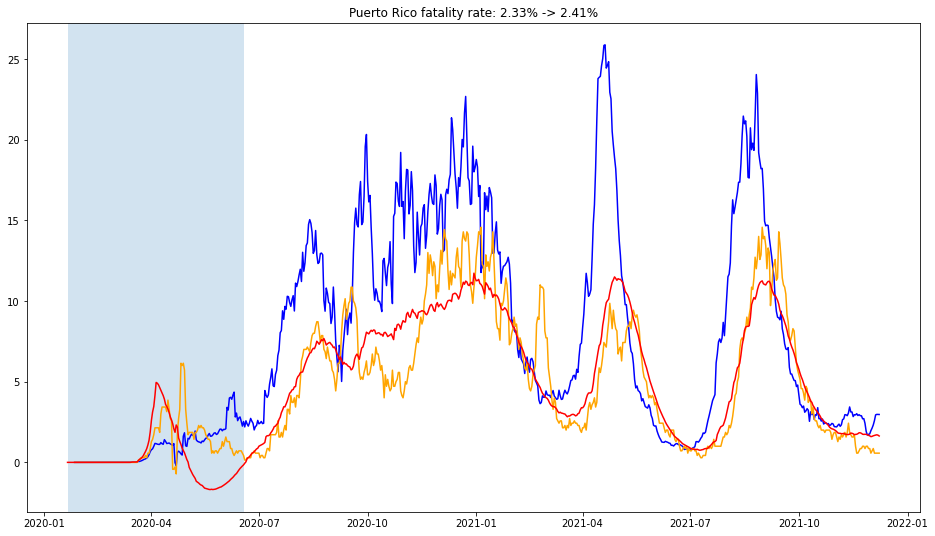

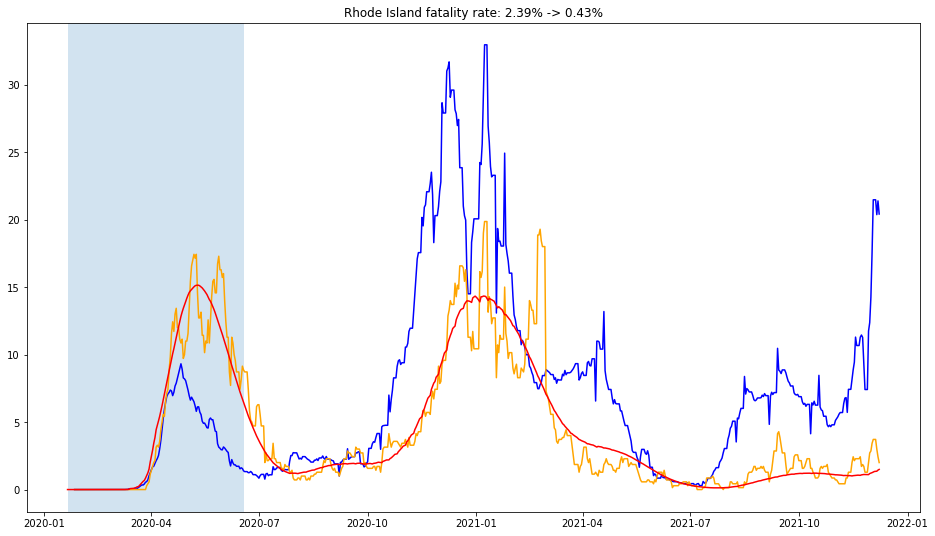

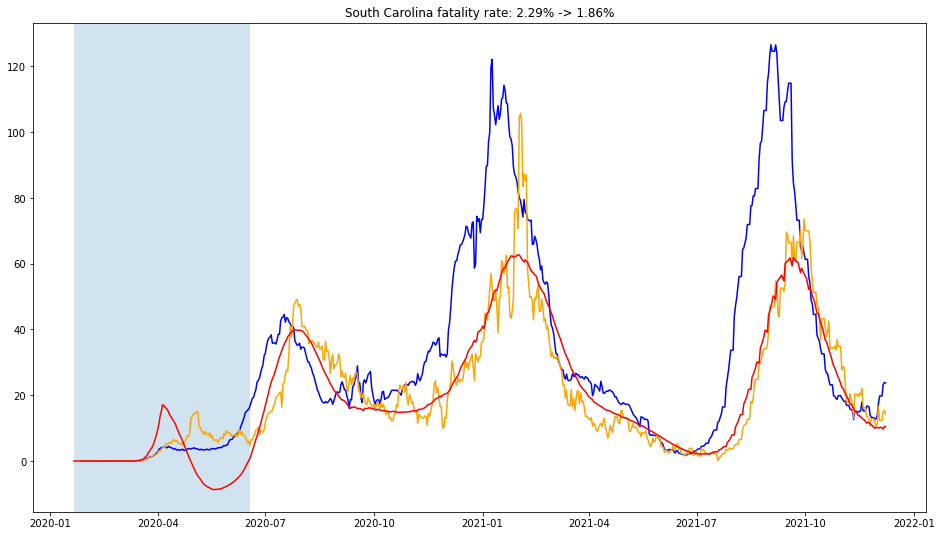

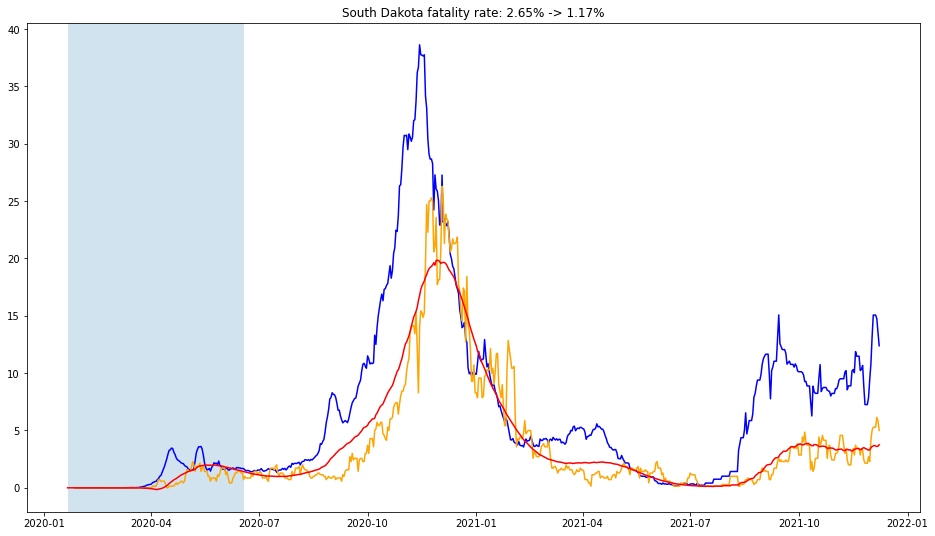

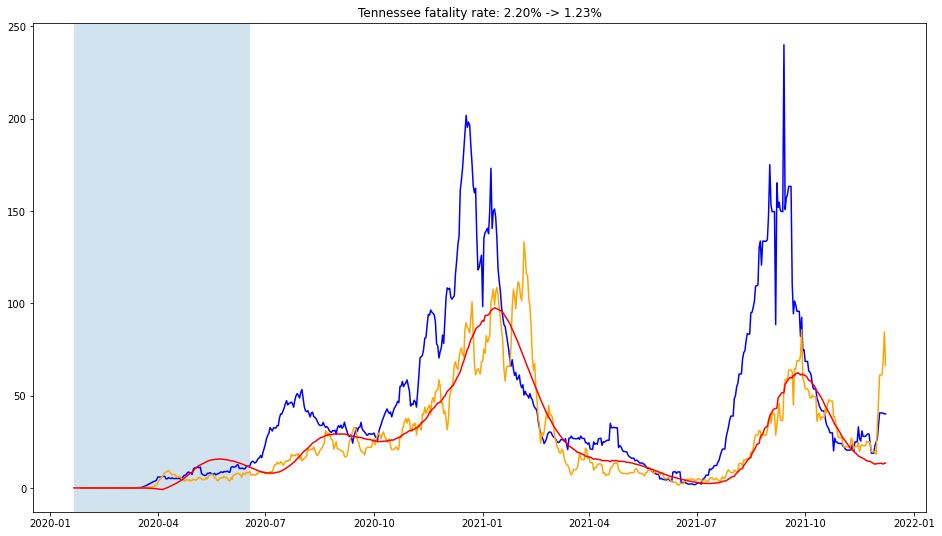

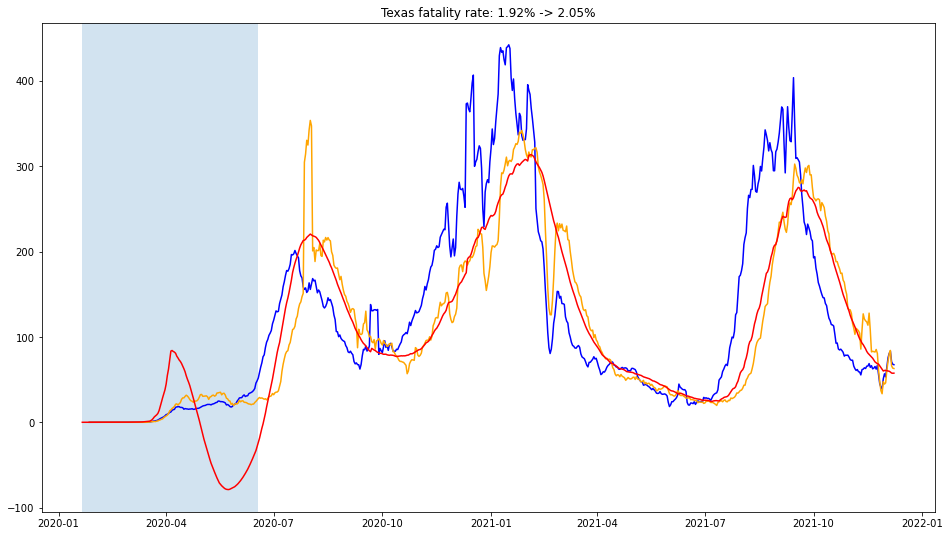

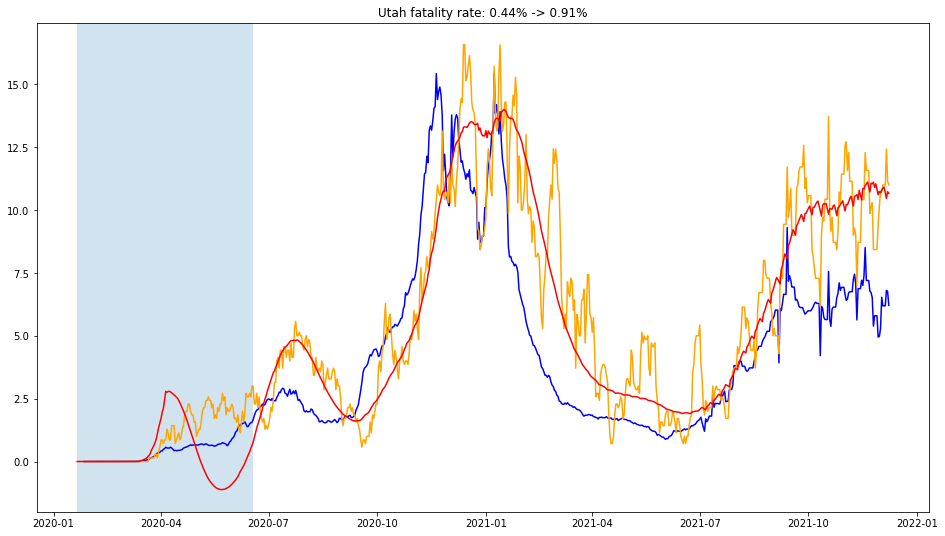

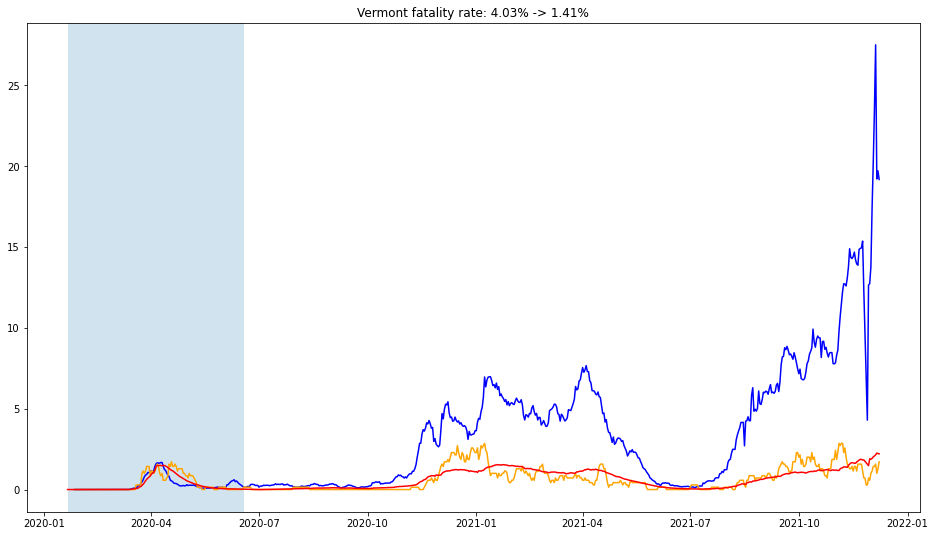

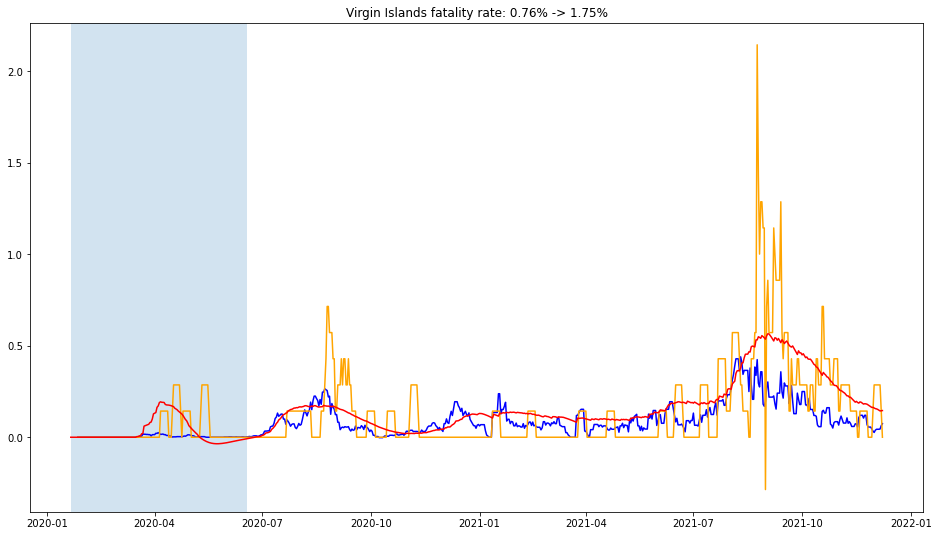

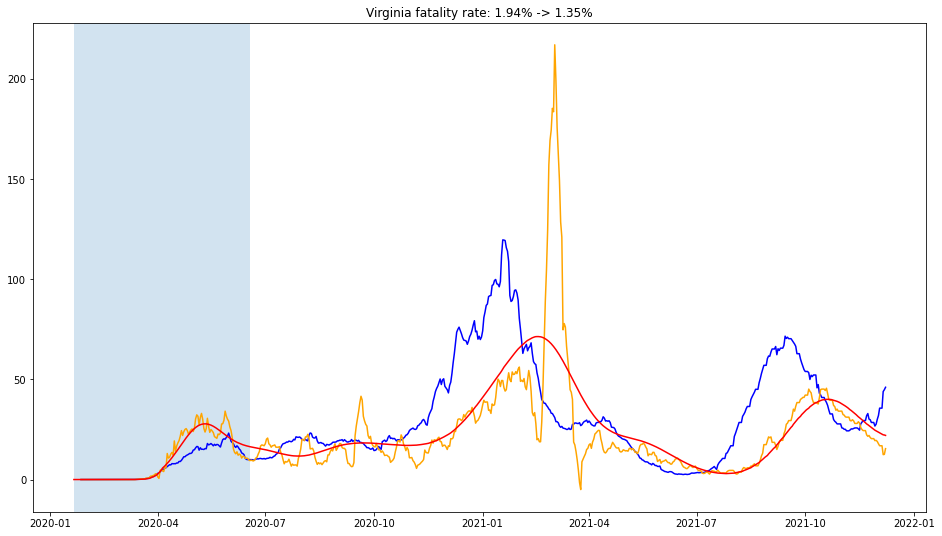

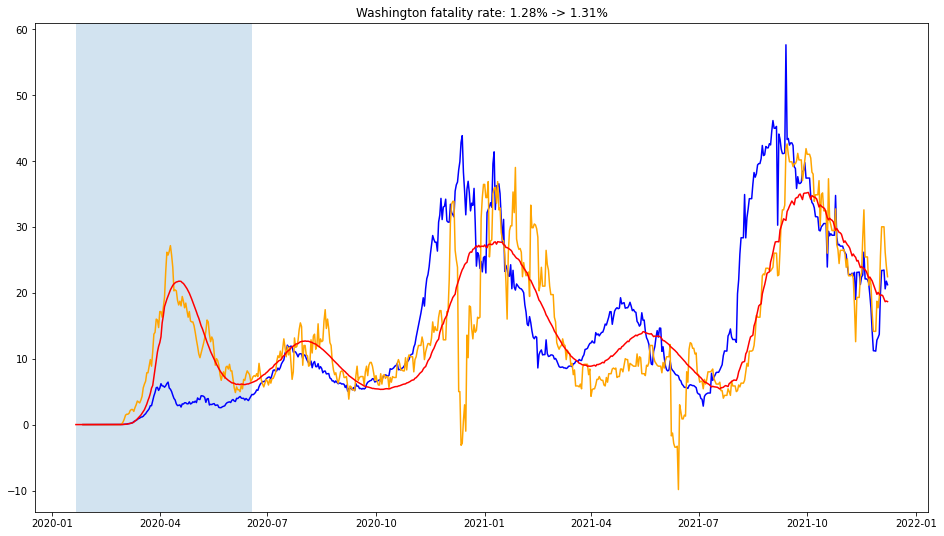

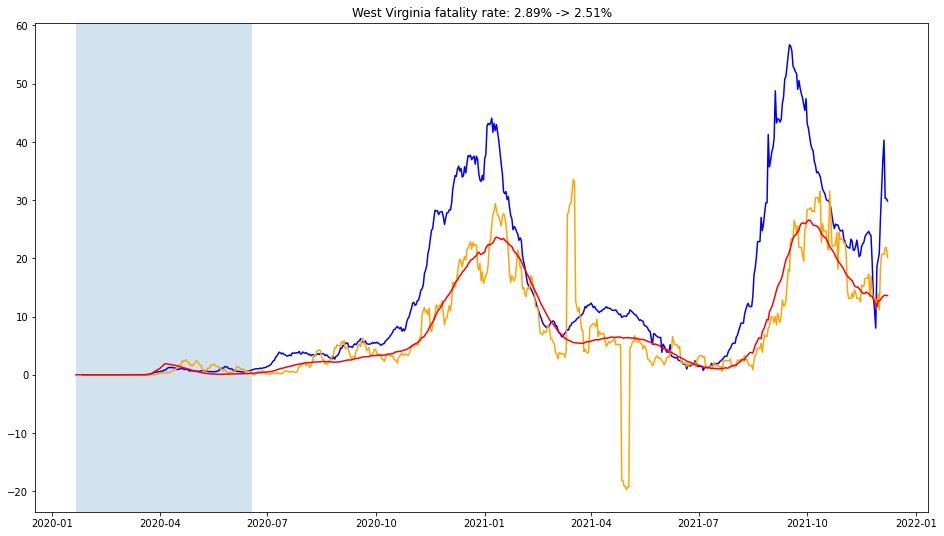

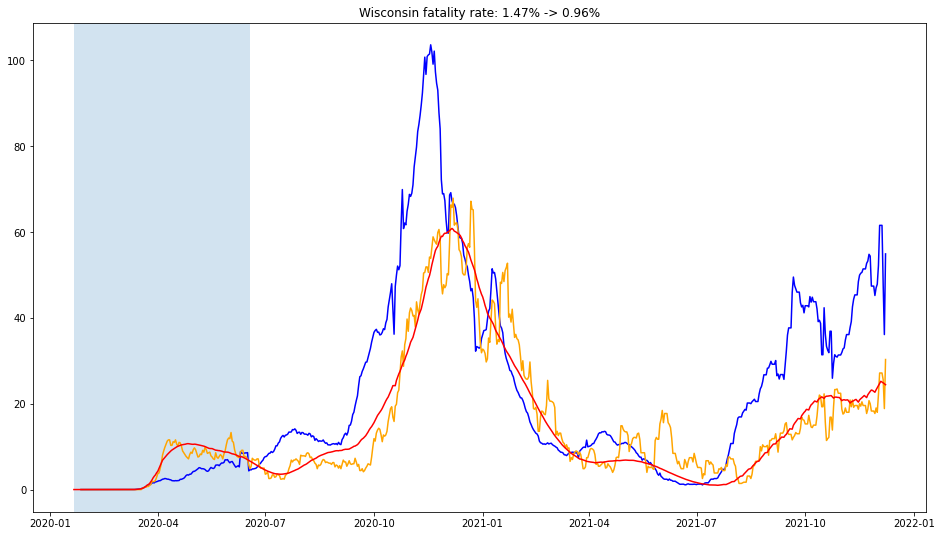

In [67]:
state_results = {}
for state in all_states:
    state_results[state] = state_fit_full(state, state_cases, state_deaths, True)

In [68]:
state_results

{'Alabama': (array([-3.57828030e-02,  1.50093365e-01,  4.44640990e-03,  2.64594999e-02,
          2.02481113e-02,  2.76776279e+01]),
  array([[ 2.87414583e+00, -2.45106954e-02,  1.35579891e-03,
          -9.93356400e-05, -1.50962876e-05,  1.86300021e-01],
         [-2.45106954e-02,  7.72638756e-03, -4.80384593e-04,
           3.34014584e-05,  1.40842915e-06, -4.43991812e-02],
         [ 1.35579891e-03, -4.80384593e-04,  8.93606829e-05,
          -6.43950460e-06,  7.75574858e-07,  3.35979956e-03],
         [-9.93356400e-05,  3.34014584e-05, -6.43950460e-06,
           4.80964937e-06, -8.68072181e-07, -1.12761429e-03],
         [-1.50962876e-05,  1.40842915e-06,  7.75574858e-07,
          -8.68072181e-07,  1.78403549e-06, -1.31516062e-03],
         [ 1.86300021e-01, -4.43991812e-02,  3.35979956e-03,
          -1.12761429e-03, -1.31516062e-03,  7.80798304e+00]])),
 'Alaska': (array([3.89701310e-02, 3.54537886e-02, 1.19713590e-02, 4.68070643e-03,
         8.80037887e-03, 1.37351840e+01]),


In [69]:
np.linalg.det(state_results['Illinois'][1])

2.88889293350686e-22

In [70]:
np.linalg.det(state_results['Michigan'][1])

2.000269492311266e-17

In [71]:
states = state_results.keys()
for state in states:
    p = state_results[state][0]
    ratio = p[4]/p[3]
    print(f"{state}: {ratio:0.2f}")

Alabama: 0.77
Alaska: 1.88
American Samoa: 1.00
Arizona: 0.66
Arkansas: 0.71
California: 0.59
Colorado: 0.75
Connecticut: 0.27
Delaware: 0.56
District of Columbia: 0.15
Florida: 1.31
Georgia: 1.09
Guam: 0.65
Hawaii: 0.61
Idaho: 2.16
Illinois: 0.56
Indiana: 0.74
Iowa: 0.65
Kansas: 0.56
Kentucky: 0.97
Louisiana: 0.74
Maine: 0.41
Maryland: 0.85
Massachusetts: 0.30
Michigan: 0.59
Minnesota: 0.60
Mississippi: 0.65
Missouri: 1.22
Montana: 1.22
Nebraska: 0.31
Nevada: 1.19
New Hampshire: 0.41
New Jersey: 0.26
New Mexico: 0.51
New York: 0.38
North Carolina: 0.75
North Dakota: 0.50
Northern Mariana Islands: -2.32
Ohio: 0.83
Oklahoma: 3.54
Oregon: 0.89
Pennsylvania: 0.43
Puerto Rico: 1.03
Rhode Island: 0.18
South Carolina: 0.81
South Dakota: 0.44
Tennessee: 0.56
Texas: 1.07
Utah: 2.07
Vermont: 0.35
Virgin Islands: 2.29
Virginia: 0.69
Washington: 1.02
West Virginia: 0.87
Wisconsin: 0.65
Wyoming: 1.37
